In [59]:
import sys

import pandas 
import scipy

import matplotlib.pyplot
import seaborn

import networkx

sys.path.append("../scripts")
from utils import parse_interactome

In [60]:
def parse_scores(scores_file):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores[ENSG] = float(score)

    return scores

In [61]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores_left_out[ENSG] = float(score)
        
    return scores_left_out

In [62]:
def compare_scores(scores, scores_left_out):
    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, p_value = scipy.stats.ranksums(df_scores['score'].values, df_scores_left_out['score'].values, alternative='less')

    return df_compare, p_value

In [63]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [64]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [65]:
PHENOTYPE = "MMAF"
ALPHA = 0.1
D_MAX = 10

#### Load the necessary data

In [66]:
interactome = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

alpha = str(ALPHA).replace('.', '')
scores = parse_scores(f"/home/kubicaj/calc/output/PageRank/alpha{alpha}_dmax{D_MAX}/scores.tsv")
scores_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/PageRank/alpha{alpha}_dmax{D_MAX}/scores_leave_one_out.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [67]:
df_compare, p_value = compare_scores(scores, scores_leave_one_out)

Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)\nalpha=0.1,   d=10')

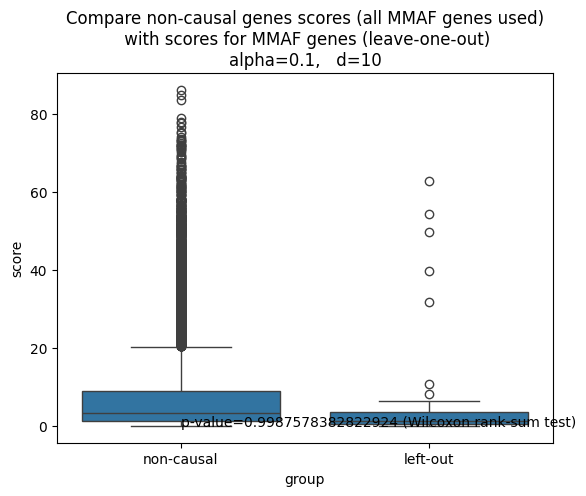

In [68]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nalpha={ALPHA},   d={D_MAX}")

In [69]:
# top 10 high-scoring genes
scores_sorted = {node: score for node, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
scores_sorted

{'ENSG00000083535': 86.09221461328286,
 'ENSG00000135249': 84.80822104477488,
 'ENSG00000101004': 83.5797390352449,
 'ENSG00000156735': 78.97902831823424,
 'ENSG00000223501': 77.92835922065161,
 'ENSG00000137218': 77.60988718464552,
 'ENSG00000182195': 76.631180239542,
 'ENSG00000100065': 75.25296068836438,
 'ENSG00000167604': 75.05948492106063,
 'ENSG00000161509': 74.08040996976452,
 'ENSG00000166946': 73.64472395980422,
 'ENSG00000150636': 73.2979205678867,
 'ENSG00000171444': 73.04779543756015,
 'ENSG00000101624': 72.94251152207315,
 'ENSG00000186628': 72.60899809812659,
 'ENSG00000160202': 71.98112615789589,
 'ENSG00000163060': 71.98099954111086,
 'ENSG00000183690': 71.85188529047686,
 'ENSG00000184708': 71.83606932588043,
 'ENSG00000197079': 71.50048811496893,
 'ENSG00000166407': 71.48042620064749,
 'ENSG00000110367': 71.06281073720277,
 'ENSG00000117475': 70.84385059572975,
 'ENSG00000071539': 70.68245265328781,
 'ENSG00000084652': 70.24421838038786,
 'ENSG00000070748': 69.524082

#### Scores analysis newCentrality_v4 more info

In [70]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

nonCausal_genes_list = [k for k, v in causal_genes.items() if v == 0]
causal_genes_list = [k for k, v in causal_genes.items() if v == 1]

for source_node in nonCausal_genes_list:
    dict_tmp = {}

    for target_node in causal_genes_list:
        try:
            distance = networkx.shortest_path_length(interactome, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

NameError: name 'causal_genes' is not defined

In [ ]:
# get more info about each node (degree, causal genes at distances)
for n, score in scores_sorted.items():
    scores_sorted[n] = [score, 
                        interactome.degree(n), 
                        (n in causal_genes_list),
                        causal_genes_at_distance(dict_distances, n, 1), 
                        causal_genes_at_distance(dict_distances, n, 2),
                        causal_genes_at_distance(dict_distances, n, 3),
                        causal_genes_at_distance(dict_distances, n, 4)]

df = pandas.DataFrame.from_dict(scores_sorted, 
                                orient='index', 
                                columns=['score', 'degree', 'isCausal', 'causal genes at d=1', 'causal genes at d=2', 'causal genes at d=3', 'causal genes at d=4'])

NameError: name 'causal_genes_list' is not defined

In [ ]:
seaborn.regplot(data=df, x="degree", y="score")
matplotlib.pyplot.title("New centrality scores vs. node degree")

NameError: name 'df' is not defined

#### Analyze new candidates from 13/02/2024

In [71]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [72]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [73]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [74]:
scores_new_candidates

{'ENSG00000162994': 1.1128797781222228,
 'ENSG00000025293': 0.5000848625555557,
 'ENSG00000164287': 9.217306244148688,
 'ENSG00000188732': 5.402699968342819,
 'ENSG00000128310': 0.3030304175166668,
 'ENSG00000165115': 1.6272630882691521,
 'ENSG00000180376': 0.718896811634409,
 'ENSG00000133101': 9.220382141209896,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 0.3948844991259261,
 'ENSG00000136449': 1.3769151338292431,
 'ENSG00000078814': 3.908174850366819,
 'ENSG00000165698': 1.9427104070612202,
 'ENSG00000170469': 3.55411009054714,
 'ENSG00000132122': 3.038326875501678,
 'ENSG00000139908': 0.5562551531054548,
 'ENSG00000120440': 0.13306566084000007}

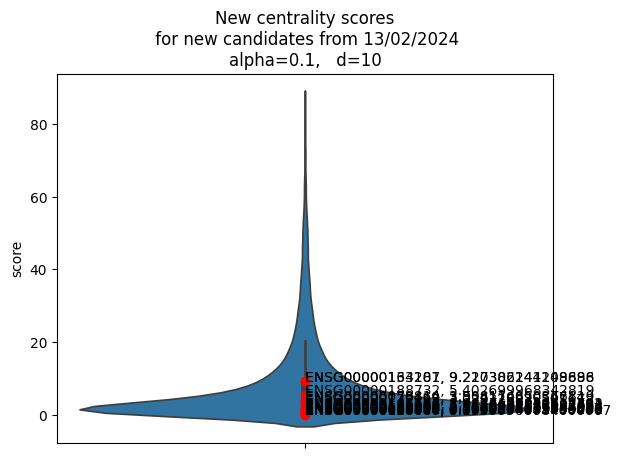

In [75]:
seaborn.violinplot(data=df_compare, y='score')
matplotlib.pyplot.title(f"New centrality scores\n for new candidates from 13/02/2024\nalpha={ALPHA},   d={D_MAX}")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")